# Analysis of commonly used words (English Language)

### Load packages:

In [1]:
using TextAnalysis
using JSON, OAuth, Twitter
using Colors
using ColorSchemes
using JLD
using Statistics
using XLSX
using CSV
using DataFrames
using Dates
using LinearAlgebra
using StatsBase
using MultivariateStats

### Plotting settings:

In [2]:
import Plots
import PyPlot
Plots.pyplot()

plt = PyPlot

SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = vcat([0 0 0 0], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:]);

### Define some useful functions:

In [3]:
conv_to_hour(date) = dayofyear.(date).*24 .+ hour.(date)
conv_to_minumte(date) = dayofyear.(date).*24.0 .* 60.0 .+ hour.(date) .* 60.0 .+ minute.(date)
conv_to_seconds(date) = dayofyear.(date).*24.0 .* 60.0 .* 60.0 .+ hour.(date) .* 60.0 .* 60.0 .+ minute.(date) .* 60.0 .+ second.(date)
conv_to_hmin(date) = hour.(date) .* 60.0 .+ minute.(date) 

function linreg(x, y; bias_c=true)
    
	X = Array{Float64}(undef, length(x),1)
	Y = Vector{Float64}(undef, length(y))
	X[1:length(x),1] .= x
	Y[1:length(y)] .= y
	sol = llsq(X, Y)
	coeff, bias = sol[1], sol[2]
    
    if bias_c == true
        g1(x) = bias + coeff*x 
        return g1, (coeff, bias)
    end
    
    if bias_c == false
        g2(x) = coeff*x
        return g2, (coeff, bias)
    end
    
end

linreg (generic function with 1 method)

### Load data files:

In [4]:
new_df = XLSX.readxlsx("covid-en.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

data_tmp = new_df["A2:$stop_ind"];

df_1 = DataFrame(data_tmp,  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang]);

# Top Tweets:

## retweets

In [5]:
mask = sortperm(df_1[:,1], rev=true)[1:10]
df_1[mask,:]

,retweet_count,favorite_count,created_at,text
,Any,Any,Any,Any
1,6593,14509,2020-04-14T15:59:41,"Every time a hospital admits, discharges, or loses a patient to Covid-19, they are compensated 15% more according to the CARES ACT, SEC 4409. \n\nNYC was facing a hospital budget crisis and you fixed it for them. They are inflating all of their #coronavirus numbers. https://t.co/sH1N18lpfB"
2,6469,23320,2020-04-15T23:50:34,I asked my students (for extra credit) to select one COVID-19 artifact that they would suggest to a historian 100 years from now for an exhibit. The results are moving and heartbreaking. The only rule was they couldn't say anything medical since that would be easy (masks etc)
3,5555,13004,2020-04-15T11:47:17,"FUN FACT: If Trump had enacted social distancing measures just TWO WEEKS EARLIER, nearly 90% of the COVID-19 deaths could have been prevented.\n#TrumpOwnsEveryDeath #70DayDeadlyDelay"
4,5399,18009,2020-04-13T22:08:01,Inside coronavirus briefing President Trump is having reporters watch campaign style montage praising his handling of coronavirus. #Covid_19 https://t.co/Idq26FKYqQ
5,5366,10049,2020-04-11T17:08:33,This is an extraordinary calamity. A mark in U.S. history that will never be forgotten. The historical record matters. So we assembled a large collection of these emails and have posted them here online. Here they are for you all to read. Click on link: https://t.co/HRyAhgMFWW https://t.co/LV1ZgTdhqk
6,5345,19609,2020-04-17T07:06:20,"Covid-19 crisis:\n\nIndia sending Hydroxychloroquine to 55 nations\n\nNow, Pakistan has asked India to help by providing Hydroxychloroquine medicine\n\n5 days ago, 3 civilians, including child &amp; woman, killed in J&amp;K's Kupwara due to shelling by Pakistan Army\n\nDoes Pak deserve humanity?"
7,5142,16326,2020-04-13T06:56:58,"A Covid-19 patient was booked by Police after he spat on a nurse treating him at hospital in Tamil Nadu's Tiruchirappalli\n\nHe also removed his mask &amp; threw it at the nurse, enraging the hospital staff &amp; other patients.\n\nHe's from the 'single source' event.\n\nWhat's single source ?"
8,3922,5791,2020-04-15T17:53:34,"Under the CARES Act, hospitals get paid 15% more by Medicare if they classify their patients as having “a principal or secondary diagnosis of COVID-19.” Get ready for every hospital in America to pass off everyday coughing as “suspected COVID-19.” https://t.co/JXTVUmgriv #Covid19"
9,3787,20624,2020-04-13T16:37:27,"Dominic Raab says 'our plan is working - it's been a success so far.'\nJust to remind him, 11,329 have died in UK so far &amp; we're tracking to have worst #coronavirus death toll in Europe. \nThe Govt's also badly failed on tests, ventilators &amp; PPE.\nWe needed a different plan."


## favorite:

In [6]:
mask = sortperm(df_1[:,2], rev=true)[1:10]
df_1[mask,:]

,retweet_count,favorite_count,created_at,text
,Any,Any,Any,Any
1,6469,23320,2020-04-15T23:50:34,I asked my students (for extra credit) to select one COVID-19 artifact that they would suggest to a historian 100 years from now for an exhibit. The results are moving and heartbreaking. The only rule was they couldn't say anything medical since that would be easy (masks etc)
2,3787,20624,2020-04-13T16:37:27,"Dominic Raab says 'our plan is working - it's been a success so far.'\nJust to remind him, 11,329 have died in UK so far &amp; we're tracking to have worst #coronavirus death toll in Europe. \nThe Govt's also badly failed on tests, ventilators &amp; PPE.\nWe needed a different plan."
3,5345,19609,2020-04-17T07:06:20,"Covid-19 crisis:\n\nIndia sending Hydroxychloroquine to 55 nations\n\nNow, Pakistan has asked India to help by providing Hydroxychloroquine medicine\n\n5 days ago, 3 civilians, including child &amp; woman, killed in J&amp;K's Kupwara due to shelling by Pakistan Army\n\nDoes Pak deserve humanity?"
4,5399,18009,2020-04-13T22:08:01,Inside coronavirus briefing President Trump is having reporters watch campaign style montage praising his handling of coronavirus. #Covid_19 https://t.co/Idq26FKYqQ
5,5142,16326,2020-04-13T06:56:58,"A Covid-19 patient was booked by Police after he spat on a nurse treating him at hospital in Tamil Nadu's Tiruchirappalli\n\nHe also removed his mask &amp; threw it at the nurse, enraging the hospital staff &amp; other patients.\n\nHe's from the 'single source' event.\n\nWhat's single source ?"
6,6593,14509,2020-04-14T15:59:41,"Every time a hospital admits, discharges, or loses a patient to Covid-19, they are compensated 15% more according to the CARES ACT, SEC 4409. \n\nNYC was facing a hospital budget crisis and you fixed it for them. They are inflating all of their #coronavirus numbers. https://t.co/sH1N18lpfB"
7,3204,13117,2020-04-12T01:19:37,"He wasn’t yet 20 when snipers’ bullets zipped past his head in Germany.\n\nHe stood guard at Nuremberg, hearing of the Nazi atrocities.\n\nShocks. Aftershocks.\n\nEmilio J. DiPalma died at 93 of the coronavirus.\n\nThere’ll be no funeral.\nPlease remember him.\n\n#COVID19 #Coronavirus https://t.co/LC93hSDmpi"
8,5555,13004,2020-04-15T11:47:17,"FUN FACT: If Trump had enacted social distancing measures just TWO WEEKS EARLIER, nearly 90% of the COVID-19 deaths could have been prevented.\n#TrumpOwnsEveryDeath #70DayDeadlyDelay"
9,3696,11235,2020-04-15T06:34:54,"It is with great sadness we announce that another member of our healthcare family, student nurse Ade Raymond, has sadly died from COVID-19. https://t.co/BHzZIUbnaM"


# Words Analysis:

In [7]:
Base.replace(s::String, oldnews::Pair...) = foldl(replace, oldnews, init=s)

contractions = [ 
    "ain't "=> "am not / are not / is not / has not / have not ",
    "aren't "=> "are not / am not ",
    "can't "=> "cannot ",
    "can't've "=> "cannot have ",
    "'cause "=> "because ",
    "could've "=> "could have ",
    "couldn't "=> "could not ",
    "couldn't've "=> "could not have ",
    "didn't "=> "did not ",
    "doesn't "=> "does not ",
    "don't "=> "do not ",
    "Don't "=> "do not ",
    "hadn't "=> "had not ",
    "hadn't've "=> "had not have ",
    "hasn't "=> "has not ",
    "haven't "=> "have not ",
    "he'd "=> "he had / he would ",
    "he'd've "=> "he would have ",
    "he'll "=> "he shall / he will ",
    "he'll've "=> "he shall have / he will have ",
    "he's "=> "he has / he is ",
    "how'd "=> "how did ",
    "how'd'y "=> "how do you ",
    "how'll "=> "how will ",
    "how's "=> "how has / how is / how does ",
    "I'd "=> "I had / I would ",
    "I'd've "=> "I would have ",
    "I'll "=> "I shall / I will ",
    "I'll've "=> "I shall have / I will have ",
    "I'm "=> "I am ",
    "I've "=> "I have ",
    "isn't "=> "is not ",
    "it'd "=> "it had / it would ",
    "it'd've "=> "it would have ",
    "it'll "=> "it shall / it will ",
    "it'll've "=> "it shall have / it will have ",
    "it's "=> "it has / it is ",
    "let's "=> "let us ",
    "ma'am "=> "madam ",
    "mayn't "=> "may not ",
    "might've "=> "might have ",
    "mightn't "=> "might not ",
    "mightn't've "=> "might not have ",
    "must've "=> "must have ",
    "mustn't "=> "must not ",
    "mustn't've "=> "must not have ",
    "needn't "=> "need not ",
    "needn't've "=> "need not have ",
    "o'clock "=> "of the clock ",
    "oughtn't "=> "ought not ",
    "oughtn't've "=> "ought not have ",
    "shan't "=> "shall not ",
    "sha'n't "=> "shall not ",
    "shan't've "=> "shall not have ",
    "she'd "=> "she had / she would ",
    "she'd've "=> "she would have ",
    "she'll "=> "she shall / she will ",
    "she'll've "=> "she shall have / she will have ",
    "she's "=> "she has / she is ",
    "should've "=> "should have ",
    "shouldn't "=> "should not ",
    "shouldn't've "=> "should not have ",
    "so've "=> "so have ",
    "so's "=> "so as / so is ",
    "that'd "=> "that would / that had ",
    "that'd've "=> "that would have ",
    "that's "=> "that has / that is ",
    "there'd "=> "there had / there would ",
    "there'd've "=> "there would have ",
    "there's "=> "there has / there is ",
    "they'd "=> "they had / they would ",
    "they'd've "=> "they would have ",
    "they'll "=> "they shall / they will ",
    "they'll've "=> "they shall have / they will have ",
    "they're "=> "they are ",
    "they've "=> "they have ",
    "to've "=> "to have ",
    "wasn't "=> "was not ",
    "we'd "=> "we had / we would ",
    "we'd've "=> "we would have ",
    "we'll "=> "we will ",
    "we'll've "=> "we will have ",
    "we're "=> "we are ",
    "we've "=> "we have ",
    "weren't "=> "were not ",
    "what'll "=> "what shall / what will ",
    "what'll've "=> "what shall have / what will have ",
    "what're "=> "what are ",
    "what's "=> "what has / what is ",
    "what've "=> "what have ",
    "when's "=> "when has / when is ",
    "when've "=> "when have ",
    "where'd "=> "where did ",
    "where's "=> "where has / where is ",
    "where've "=> "where have ",
    "who'll "=> "who shall / who will ",
    "who'll've "=> "who shall have / who will have ",
    "who's "=> "who has / who is ",
    "who've "=> "who have ",
    "why's "=> "why has / why is ",
    "why've "=> "why have ",
    "will've "=> "will have ",
    "won't "=> "will not ",
    "won't've "=> "will not have ",
    "would've "=> "would have ",
    "wouldn't "=> "would not ",
    "wouldn't've "=> "would not have ",
    "y'all "=> "you all ",
    "y'all'd "=> "you all would ",
    "y'all'd've "=> "you all would have ",
    "y'all're "=> "you all are ",
    "y'all've "=> "you all have ",
    "you'd "=> "you had / you would ",
    "you'd've "=> "you would have ",
    "you'll "=> "you shall / you will ",
    "you'll've "=> "you shall have / you will have ",
    "you're "=> "you are ",
    "you've "=> "you have "];

In [8]:
data_preprocessed = df_1[:,4]

data_preprocessed = replace.(data_preprocessed, r"http\S+" => s"")
data_preprocessed = replace.(data_preprocessed, r"\S+.com" => s"")
data_preprocessed = replace.(data_preprocessed, r"resulting" => s"")
data_preprocessed = replace.(data_preprocessed, r"RESULTING" => s"")
data_preprocessed = replace.(data_preprocessed, r"#resulting" => s"")
data_preprocessed = replace.(data_preprocessed, r"@\S+" => s"")
data_preprocessed = replace.(data_preprocessed, r"&amp" => s"")
data_preprocessed = replace.(data_preprocessed, r"RT\S+" => s"");
data_preprocessed = replace.(data_preprocessed, contractions...);

In [9]:
crps_1 = Corpus(StringDocument.(deepcopy(data_preprocessed)));

remove_case!(crps_1)
prepare!(crps_1, strip_punctuation)
prepare!(crps_1, strip_numbers)
prepare!(crps_1, strip_articles)

prepare!(crps_1, strip_pronouns)
prepare!(crps_1, strip_prepositions)
prepare!(crps_1, strip_definite_articles)
prepare!(crps_1, strip_indefinite_articles)

prepare!(crps_1, strip_stopwords)
prepare!(crps_1, strip_non_letters)
remove_words!(crps_1, ["don", "re", "ve", "ll", "covid", "coronavirus"])
# stem!(crps_1)
prepare!(crps_1, strip_whitespace)


In [10]:
text_1 = StringDocument(prod(text.(crps_1)))

n_gram_1 = collect(ngrams(text_1, 1))
n_gram_2 = collect(ngrams(text_1, 2));

In [11]:
top_range = collect(1:30)
names_tmp = sort(n_gram_1, by=x->last(x), rev=true)[top_range]; #[top_range]

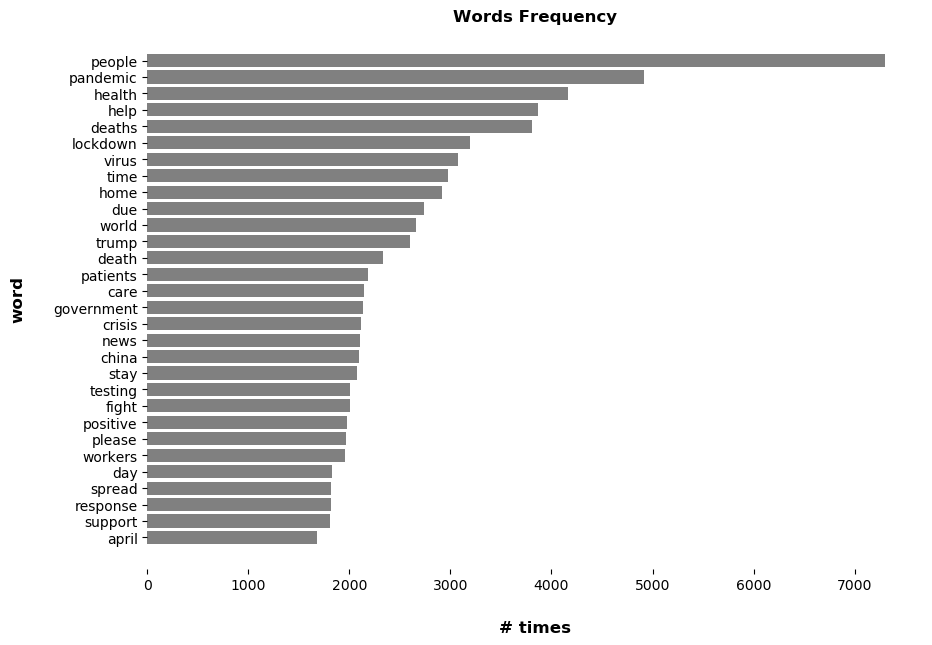

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10, 7))

ax.barh(top_range, last.(names_tmp), align="center", color="gray")

ax.set_yticks(top_range)
ax.set_yticklabels(first.(names_tmp))
ax.invert_yaxis()  # labels read top-to-bottom

ax.spines["right"].set_visible(false)

ax.spines["top"].set_visible(false)
ax.spines["left"].set_visible(false)
ax.spines["bottom"].set_visible(false)

# ax.legend(loc="center right", frameon=true, framealpha=0.8, ncol=1)

ax.set_ylabel("word",  labelpad=20, weight="bold", size=12)
ax.set_xlabel("# times", labelpad=20, weight="bold", size=12)
ax.set_title("Words Frequency", weight="bold", size=12);

In [13]:
bigram_mask = length.(tokens.(StringDocument.(first.(n_gram_2)))) .== 2

names_bigram = sort(n_gram_2[bigram_mask], by=x->last(x), rev=true)[top_range]; #[top_range]

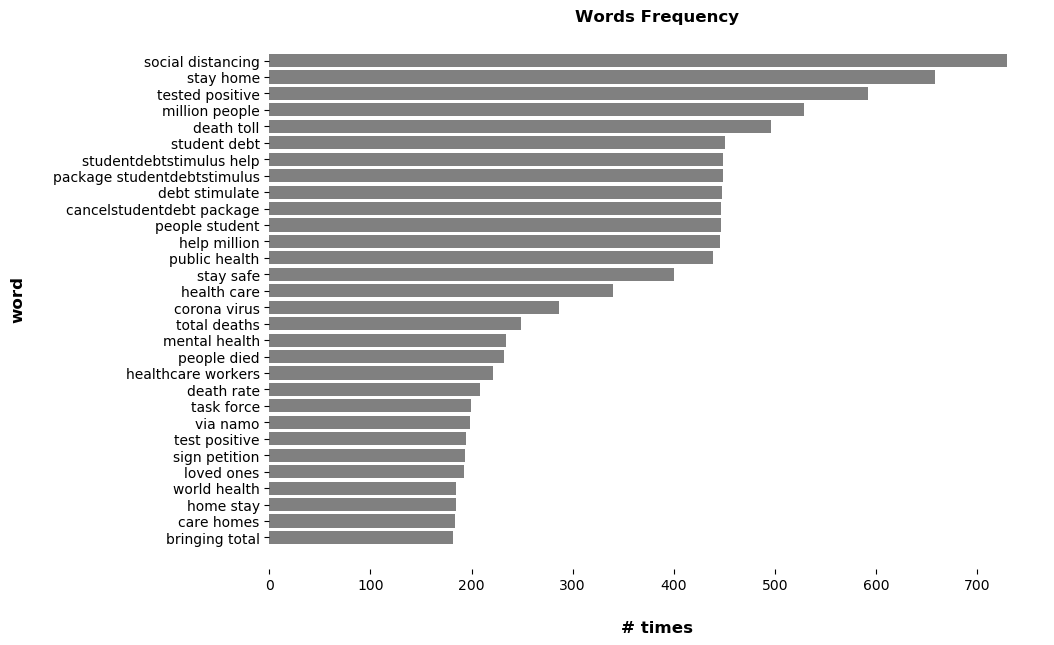

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10, 7))

ax.barh(top_range, last.(names_bigram), align="center", color="gray")

ax.set_yticks(top_range)
ax.set_yticklabels(first.(names_bigram))
ax.invert_yaxis()  # labels read top-to-bottom

ax.spines["right"].set_visible(false)

ax.spines["top"].set_visible(false)
ax.spines["left"].set_visible(false)
ax.spines["bottom"].set_visible(false)

ax.set_ylabel("word",  labelpad=20, weight="bold", size=12)
ax.set_xlabel("# times", labelpad=20, weight="bold", size=12)
ax.set_title("Words Frequency", weight="bold", size=12)

# ax.legend(loc="center right", frameon=true, framealpha=0.8, ncol=1);